In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import ast

In [2]:
# Loading the data set.
gameDf = pd.read_csv('gameDf.csv')

In [3]:
# The csv has the list of chat messages as a single string. This function recovers the python list.
gameDf['chatsclean'] = gameDf['chatsclean'].apply(ast.literal_eval)

In [4]:
# BoW encoding, text has already been processed.
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x,lowercase=False)

In [5]:
# Creating machine learning matricies and performing train-test split for validation.
X = vectorizer.fit_transform(gameDf['chatsclean'].tolist()).toarray()
y = gameDf['result'].to_numpy()
XTrain, XTest, yTrain, yTest = train_test_split(X,y,random_state=42)

In [6]:
# Creating parameter space and fitting models using grid search.
paramGrid = {'C': [2 ** n for n in range(-5,17,2)],  
              'gamma': [2 ** n for n in range(-15,5,2)], 
              'kernel': ["linear"]}  

grid = GridSearchCV(SVC(class_weight="balanced"), paramGrid, verbose = 0) 
grid.fit(XTrain,yTrain)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048,
                               8192, 32768],
                         'gamma': [3.0517578125e-05, 0.0001220703125,
                                   0.00048828125, 0.001953125, 0.0078125,
                                   0.03125, 0.125, 0.5, 2, 8],
                         'kernel': ['linear']})

In [7]:
# Fitting the best model found in grid search to the data set.
grid.best_estimator_.fit(XTrain,yTrain)

SVC(C=0.125, class_weight='balanced', gamma=3.0517578125e-05, kernel='linear')

In [8]:
# Printing all metrics of interest: fraction of "win" predictions, train/test accuracy, and f1-score.
print(sum(grid.best_estimator_.predict(XTest))/len(grid.best_estimator_.predict(XTest)))
print(grid.best_estimator_.score(XTrain,yTrain))
print(grid.best_estimator_.score(XTest,yTest))
print(classification_report(yTest, grid.best_estimator_.predict(XTest))) 

0.7021276595744681
0.7428571428571429
0.6382978723404256
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        42
           1       0.64      0.81      0.71        52

    accuracy                           0.64        94
   macro avg       0.64      0.62      0.61        94
weighted avg       0.64      0.64      0.62        94



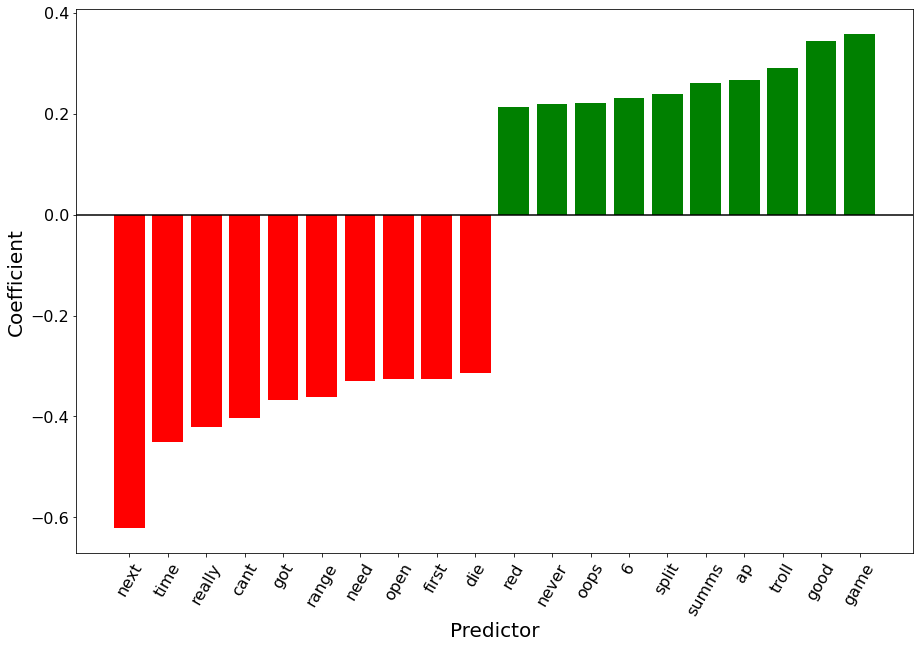

In [9]:
# Plotting feature importance.
svmCoef = grid.best_estimator_.coef_.flatten()
svmFeat = np.array(vectorizer.get_feature_names())
indexMax = np.argsort(svmCoef)[-10:]
indexMin = np.argsort(svmCoef)[:10]
svmCoefTop = np.hstack([svmCoef[indexMin],svmCoef[indexMax]])
svmFeatTop = np.hstack([svmFeat[indexMin],svmFeat[indexMax]])
colour = ['green' if i > 0 else 'red' for i in svmCoefTop]
plt.figure(figsize=(15,10))
plt.bar(np.arange(20),svmCoefTop,color=colour)
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(ticks=np.arange(20),labels=svmFeatTop,rotation=60,fontsize=16)
plt.xlabel("Predictor",fontsize=20)
plt.ylabel("Coefficient",fontsize=20)
plt.yticks(fontsize=16)
plt.show()